In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import preprocessing
import informe
from sklearn.metrics import plot_roc_curve, classification_report

from sklearn.model_selection import GridSearchCV 
from sklearn import svm

sns.set()

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Preprocesamiento

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.remove_irrelevant_features(X)
X = preprocessing.one_hot_encoding(X)

# Se separa el dataset en entrenamiento y validación
y = df.tiene_alto_valor_adquisitivo
X_train, X_val, y_train, y_val = preprocessing.dataset_split(X, y, test_size=0.85)

# Se separa el dataset de validacion en 2 partes, X_val para seleccionar el mejor modelo de knn y X_holdout para el test final
X_val, X_holdout, y_val, y_holdout = preprocessing.dataset_split(X_val, y_val, 0.2)

# Escalado
X_train, scalar = preprocessing.escalar(X_train)
X_val, scalar = preprocessing.escalar(X_val, scalar)
X_holdout, scalar = preprocessing.escalar(X_holdout, scalar)

Se aplicó un escalado de los datos numéricos de todo el dataset porque ayudó mucho a acelerar el procesamiento del método. No se pudo probar la performance del modelo sin escalado debido al alto tiempo de entrenamiento que era necesario. Además, se tomó una proporción de solo el 15% de los datos para entrenar.

# SVM: entrenamiento y búsqueda de hiperparámetros.

Lo primero que se vio al entrenar el modelo fue que la alta dimensionalidad de los datos hacían que el entrenamiento fuera demasiado costoso. Por lo tanto, no se pudo evaluar el rendimiento del modelo sin usar algún tipo de reducción dimensional. Se evaluó el desempeño con dos tipos distintos de reducción dimensional y aplicando normalización de los features numéricos.

Se usa GridSearch para buscar la mejor combinación de hiperparámetros. Se elige la mejor combinación según su score ROC-AUC. 

In [4]:
params = [
    {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', 'sigmoid']},
    {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['poly'], 'degree': [2, 3]}
]

## Modelo 1

Se entrena un modelo de SVM con los datos originales. Se usan todos los features.

In [5]:
clf = svm.SVC(cache_size = 2000)

modelo1 = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5
).fit(X_train, y_train)

modelo1.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

### Métricas


Resultados SVM modelo 1:
    Mejores hiperparámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Métrica AUC ROC: 0.89
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     16809
           1       0.75      0.54      0.63      5332

    accuracy                           0.85     22141
   macro avg       0.81      0.74      0.76     22141
weighted avg       0.84      0.85      0.84     22141



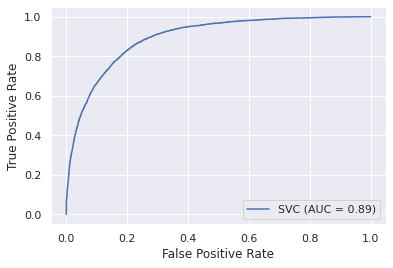

In [6]:
informe.imprimir_metricas(modelo1, X_val, y_val, 'SVM modelo 1:')
roc = plot_roc_curve(modelo1.best_estimator_, X_val, y_val)

## Modelo 2: datos normalizados

Se entrena un modelo de SVM con los datos numéricos normalizados por fila. Se usan todos los features.

In [7]:
X_train_n, normalizer = preprocessing.normalizar(X_train)
X_val_n, _ = preprocessing.normalizar(X_val, normalizer)

In [8]:
clf = svm.SVC(cache_size = 2000)

modelo2 = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5
).fit(X_train, y_train)

modelo2.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

### Métricas


Resultados SVM modelo 2:
    Mejores hiperparámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Métrica AUC ROC: 0.89
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     16809
           1       0.75      0.54      0.63      5332

    accuracy                           0.85     22141
   macro avg       0.81      0.74      0.76     22141
weighted avg       0.84      0.85      0.84     22141



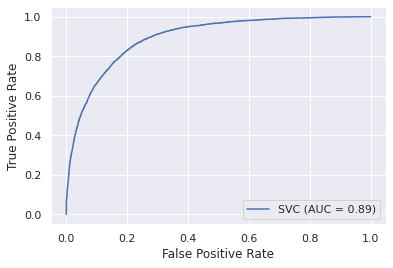

In [9]:
informe.imprimir_metricas(modelo2, X_val, y_val, 'SVM modelo 2:')
roc = plot_roc_curve(modelo2.best_estimator_, X_val, y_val)

## Modelo 3: usando pca

Se entrena un modelo de SVM aplicando PCA sobre el dataset para reducir su dimensión.

In [10]:
X_train_pca, pca = preprocessing.pca(X_train, n_components=4)
X_val_pca, _ = preprocessing.pca(X_val, pca=pca)

In [11]:
clf = svm.SVC(cache_size = 2000)

modelo3 = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5
).fit(X_train_pca, y_train)

modelo3.best_params_

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

### Métricas


Resultados SVM modelo 3:
    Mejores hiperparámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    Métrica AUC ROC: 0.85
    Otras metricas:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89     16809
           1       0.79      0.28      0.42      5332

    accuracy                           0.81     22141
   macro avg       0.80      0.63      0.65     22141
weighted avg       0.81      0.81      0.77     22141



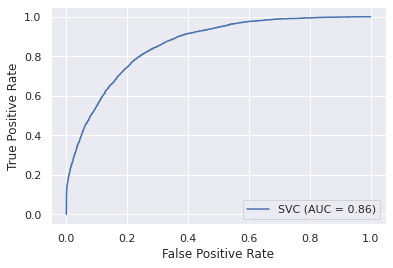

In [12]:
informe.imprimir_metricas(modelo3, X_val_pca, y_val, 'SVM modelo 3:')
roc = plot_roc_curve(modelo3.best_estimator_, X_val_pca, y_val)

## Modelo 4: datos normalizados y usando pca

Se entrena un modelo de SVM, normalizando los datos y luego aplicando PCA sobre el dataset para reducir su dimensión.

In [13]:
X_train_pca_n, pca_n = preprocessing.pca(X_train_n, n_components=4)
X_val_pca_n, _ = preprocessing.pca(X_val, pca=pca_n)

In [14]:
clf = svm.SVC(cache_size = 2000)

modelo4 = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5
).fit(X_train_pca_n, y_train)

modelo4.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

### Métricas


Resultados SVM modelo 4:
    Mejores hiperparámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Métrica AUC ROC: 0.77
    Otras metricas:


/home/tomas/FIUBA/Organización de Datos/entorno_virtual/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.76      1.00      0.86     16809
           1       0.00      0.00      0.00      5332

    accuracy                           0.76     22141
   macro avg       0.38      0.50      0.43     22141
weighted avg       0.58      0.76      0.66     22141



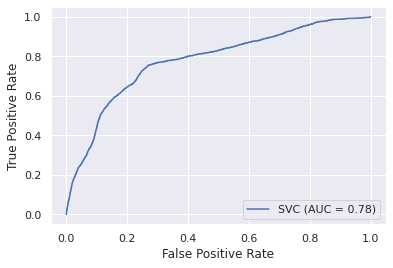

In [15]:
informe.imprimir_metricas(modelo4, X_val_pca_n, y_val, 'SVM modelo 4:')
roc = plot_roc_curve(modelo4.best_estimator_, X_val_pca_n, y_val)

# Conclusión
      En base a la metrica AUC-ROC, se elige el modelo 1.
      
### Informe del modelo usando los datos del test_holdout

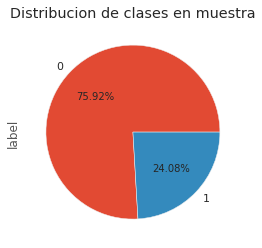

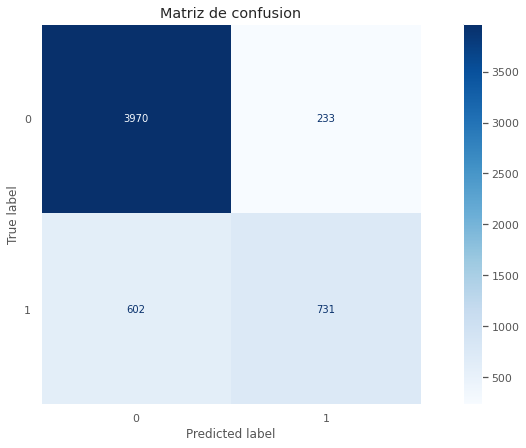

Métricas:
Resultados SVM modelo 4:
    Mejores hiperparámetros: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
    Métrica AUC ROC: 0.89
    Otras metricas:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4203
           1       0.76      0.55      0.64      1333

    accuracy                           0.85      5536
   macro avg       0.81      0.75      0.77      5536
weighted avg       0.84      0.85      0.84      5536



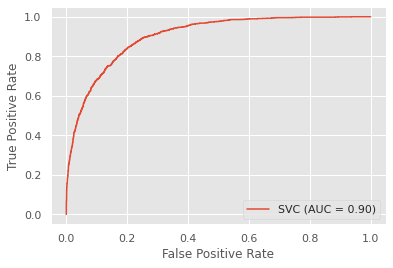

In [16]:
import sklearn

y_pred = modelo1.predict(X_holdout)

informe.plt_distribucion_de_clases(y_holdout)
informe.plot_matriz_de_confusion(modelo1, X_holdout, y_holdout)
roc = plot_roc_curve(modelo1.best_estimator_, X_holdout, y_holdout)
print('Métricas:')
informe.imprimir_metricas(modelo1, X_holdout, y_holdout, 'SVM modelo 4:')

## Conclusiones de las métricas observadas de los datos de test_holdout

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 85%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        El porcentaje de predicciones de bajos ingresos que realmente lo eran fue de 87% y el de predicciones de altos ingresos que realmente lo eran fue del 76% 


- recall:

        Los bajos ingresos reales detectados fueron aproximadamente del 94%, y los altos ingresos reales detectados fueron del 55%. Viendo este resultado, se entiende que el modelo es bueno detectando a los encuestados de bajos ingresos pero confunde al 45% de los altos ingresos como de bajos ingresos.
      
       
- matriz de confusion:
       
        Aquí tambien se puede ver que la mayoria de predicciones de bajos ingresos son correctas, pero parte de los altos ingresos reales no fueron bien predichos.
        También que aproximadamente el 85% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos ya que el accuracy era del 85%).

        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases con un score de 0.90. Este valor será utilizado para decidir sobre la elección de este modelo.

# Final test

In [21]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.one_hot_encoding(df_test)
df_test, _ = preprocessing.escalar(df_test, scalar)

y_pred = modelo1.predict(df_test)
informe.save_pred(y_pred, 'svm')